# Bayesian Inference: Activity 5
Prof. Valerio Marra

**Renan Alves de Oliveira**

**2019**

You are given a dataset $D$ with diagonal covariance matrix. The $i-$th element looks like ${x_i, d_i, \sigma_i}$, where $x_i$ is the independent variable, $d_i$ is the measurement and $\sigma_i$ is the measurement error, which is assumed to be Gaussian. Suppose that the following model $M_1$ is true: $m_1(x) = ax^2 + b^3x$.

**1. Build the posterior $f(a,b|D)$ and find the best-fit values of the parameters $a$, $b$; adopt flat improper priors. Plot the best-fit model together with an error list plot of the data.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import mpmath as mp
warnings.filterwarnings('ignore')
%matplotlib inline

from matplotlib import rc, rcParams
rc('text', usetex='True') 
rcParams.update({'font.size': 22})

# Importing the data:
data = np.loadtxt('data-f.txt')
data.shape

(51, 3)

To build the posterior, $f(a,b| D)$, we must construct all pieces of $$f(a,b|D)=\frac{f(a,b)}{f(D)}f(D|a,b).$$
Since we are assuming improper flat priors, $f(a,b)$ term cancels out with $$f(D)=\intop_{-\infty}^{+\infty}\mathrm{d}a\mathrm{d}bf(a,b)f(D|a,b).$$ The term $f(D|a,b)=\mathcal{L}(a,b)$ which is the Likelihood function
$$\mathcal{L}(a,b)=|2\pi\Sigma|^{-\frac{1}{2}}\exp{[-\frac{1}{2}\chi^2(a,b)]}.$$

In [3]:
# Defining the covariance matrix:
sigmas = data[:,-1]
cov_matrix = np.diag(sigmas**2)
cov_matrix

array([[0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.25]])

In [4]:
# Its inverse:
inverse_cov_matrix = np.linalg.inv(cov_matrix)

# Some data slicing:
d = data[:,1] # Measurements
x = data[:,0] # Independent variable

# Evaluating the constant term in the Likelihood function:
norm_term = np.sqrt(np.linalg.det(2*np.pi*cov_matrix))**(- 1)
norm_term

9.975694386982823e-06

Before defining the Likelihood module, we must write a module for $\chi^2(a,b)$, which is:

$$\chi^2(a,b)=[\boldsymbol{d}-\boldsymbol{\mu}(x,a,b)]^T \boldsymbol{\Sigma}^{-1}[\boldsymbol{d}-\boldsymbol{\mu}(x,a,b)]$$

In [5]:
def chi2_func(a,b):
    model = a*x**2 + (b**3)*x
    vector = d - model
    return np.dot(vector, np.dot(inverse_cov_matrix, vector))

And the Likelihood module will be $\mathcal{L}(a,b)$:

In [6]:
def like_func(a,b):
    return np.exp(-(1/2)*chi2_func(a,b))*norm_term

This is not necessary, however, I should point that this Likelihood is not completely normalized:

In [7]:
from scipy import integrate
integrate.dblquad(like_func, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

2.5665648052385425e-18

However, one can define a new normalized constant using:

For the term $f(D)$:

In [8]:
from scipy import integrate

def int_():
    f = lambda a, b: like_func(a,b)
    return integrate.dblquad(f, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

In [9]:
f_D = int_()
print(f_D)

2.5665648052385425e-18


Leading too the posterior:

In [10]:
def posterior(a,b):
    return like_func(a,b)/f_D

which is normalized:

In [11]:
integrate.dblquad(posterior, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

1.0000000000253713

To find the best-fit parameters for $a$ and $b$, we must minimize the $\chi^2$ function. We can find the global minimum using the `differential_evolution` method:

In [12]:
def chi2_func_forminimize(params): # minimize method only accepts an array of parameters.
                                   # the returning values should always be the same.
    a, b = params
    model = a*x**2 + (b**3)*x
    vector = d - model
    return np.dot(vector, np.dot(inverse_cov_matrix, vector))

In [13]:
from scipy.optimize import differential_evolution

In [14]:
bounds = [(-1000, 1000), (-1000, 1000)] # Bounds for the parameters.
result = differential_evolution(chi2_func_forminimize, bounds)
print('a = {}'.format(result.x[0]))
print('b = {}'.format(result.x[1]))
print('chi2min = {}'.format(result.fun))

a = result.x[0]
b = result.x[1]

a = 2.6615365854781023
b = -0.9250429354674348
chi2min = 55.556423348502605


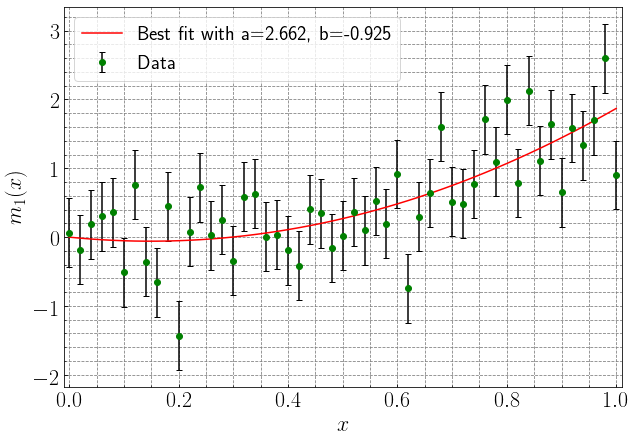

In [15]:
plt.figure(figsize=(10,7))
plt.errorbar(data[:, 0], data[:, 1], data[:, -1], fmt='og', label='Data', ecolor='k', capsize=3)
plt.plot(data[:, 0], a*data[:, 0]**2+b**3*data[:, 0], '-r', label=r'Best fit with a={}, b={}'.format(np.around(a, 3),np.around(b, 3)))
plt.legend(fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$m_1(x)$')
plt.tick_params(axis='both',direction='in', which='both')
plt.grid(which='both', color='gray', linestyle='--')
plt.minorticks_on()
plt.xlim(-0.01,1.01)

plt.show()

**2. Plot the (full) 2D posterior and the marginalized 1D posteriors. For the 2D posterior generate a contour plot for $\chi^2(a,b)=-2\ln{f(a,b|D)}$ using the Gaussian levels $\Delta\chi^2 = \{2.3, 6.2, 11.8\}$.**

In [16]:
# For the marginalized posteriors:
def mar_a(b):
    return integrate.quad(lambda a: posterior(a,b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_a = np.vectorize(mar_a)
values_ = np.arange(-2,5,.01)
marg_values_a = vec_mar_a(values_)

def mar_b(a):
    return integrate.quad(lambda b: posterior(a,b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_b = np.vectorize(mar_b)
marg_values_b = vec_mar_b(values_)

And finally, the 2-D contours for the $\chi^2$ defined before:

In [17]:
def contour_posterior(a_, b_):
    return - 2*np.log(posterior(a_, b_)) + 2*np.log(posterior(a, b))

vec_contour_posterior = np.vectorize(contour_posterior)

In [18]:
# Some values:
xa = np.linspace(0, 5.1, 1000)
yb = np.linspace(- 2., 1.2, 1000)

X, Y = np.meshgrid(xa, yb)
Z = vec_contour_posterior(X, Y)

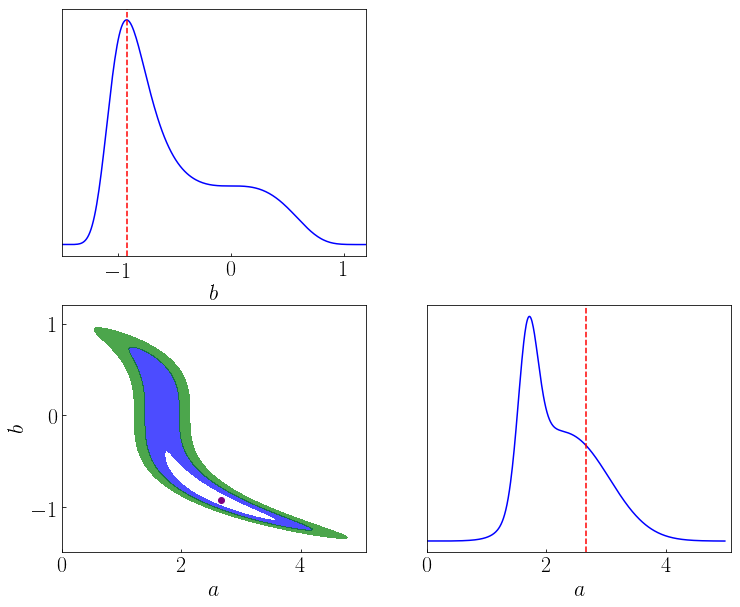

In [19]:
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(values_, marg_values_a, color='b')
plt.axvline(b, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$b$')
plt.xlim(- 1.5, 1.2)
plt.yticks([])

plt.subplot(2, 2, 3)
plt.contourf(X, Y, Z, colors=['blue','green'], alpha=0.7, levels=[2.3,6.2,11.8])
plt.scatter(a,b, color='purple')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.ylim(- 1.5, 1.2)

plt.subplot(2, 2, 4)
plt.plot(values_, marg_values_b, color='b')
plt.tick_params(axis='both',direction='in')
plt.axvline(a, color='red', linestyle='--')
plt.xlabel(r'$a$')
plt.xlim(0, 5.1)
plt.yticks([])

plt.show()

**3. Obtain the evidence $\mathcal{E}_1$. Use the flat priors: $0\leq a\leq6$ and $-2\leq b\leq2$.**

Since $f(a,b)=\frac{1}{\Delta a}\frac{1}{\Delta b}=\frac{1}{6 - 0}\frac{1}{(2 - (-2))}=\frac{1}{24}$, and then plugging this result in the expression for $f(D)$

In [20]:
# Integrate syntax: integrate.dblquad(lambda x, y: f(x,y), ymin, ymax, xmin, xmax)
from mpmath import quad
evidence_1 = integrate.dblquad(lambda a, b: (1/24)*like_func(a,b), - 2, 2, 0, 6, epsabs=1.49e-30, epsrel=1.49e-30)[0]
evidence_1

1.0693982197419712e-19

**4. Obtain the Fisher matrix $F$. Compare the exact analysis with the analysis using the Fisher matrix. Compare the 2D posteriors, the marginalized 1D posteriors and the evidence.**

To evaluate the Fisher matrix, we must evaluate some derivatives of the logarithm of the Likelihood function.

In [21]:
# I will use Sympy because derivate functions in Python is a little bit tricky :(
import sympy
A, B = sympy.symbols('A B')

fisher_terms_sympy = sympy.simplify(- sympy.log(norm_term*sympy.exp(- (1/2)*chi2_func(A,B))))

fisher_AA = sympy.diff(fisher_terms_sympy, A, 2)
fisher_AB = sympy.diff(sympy.diff(fisher_terms_sympy, A, 1), B, 1)
fisher_BA = sympy.diff(sympy.diff(fisher_terms_sympy, B, 1), A, 1)
fisher_BB = sympy.diff(fisher_terms_sympy, B, 2)

# To evaluate all terms in fisher matrix using the best-fit values:
fisher_aa = fisher_AA.subs([('A', a), ('B', b)])
fisher_ab = fisher_AB.subs([('A', a), ('B', b)])
fisher_ba = fisher_BA.subs([('A', a), ('B', b)])
fisher_bb = fisher_BB.subs([('A', a), ('B', b)])

fisher_matrix = np.array([[fisher_aa, fisher_ab], [fisher_ba, fisher_bb]], dtype=float)

In [22]:
fisher_matrix

array([[ 42.0266656 , 133.54123373],
       [133.54123373, 452.60591509]])

To obtain the 2D posterior using the Fisher matrix, $$L(\theta) = |2\pi \Sigma|^{-\frac{1}{2}} \exp[-\frac{1}{2}(\boldsymbol{\theta}_\alpha - \hat{\boldsymbol{\theta}}_\alpha)\boldsymbol{F}_{\alpha \beta}(\boldsymbol{\theta}_\beta - \hat{\boldsymbol{\theta}}_\beta)].$$

In [23]:
def likeli_fisher(a_, b_):
    best_fit = np.array([a, b])
    fisher_params = np.array([a_, b_])
    diff = best_fit - fisher_params
    return norm_term*np.exp(-(1/2)*np.dot(diff, np.dot(fisher_matrix, diff)))

This function using the Fisher Matrix is not normalized. After doing that, we'll have our posterior. To compare this result with previous one, we must do $\chi^2_\mathrm{fisher}=-2\log f_\mathrm{}$

In [24]:
norm_term_fisher = integrate.dblquad(likeli_fisher, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]
norm_term_fisher # f_D from Fisher

1.818310031639595e-06

In [25]:
def posterior_fisher(a_, b_):
    return likeli_fisher(a_, b_)/norm_term_fisher

In [26]:
integrate.dblquad(posterior_fisher, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

1.0000000000002112

In [27]:
# Contour values:
def contour_posterior_fisher(a_, b_):
    return - 2*np.log(posterior_fisher(a_,b_)) + 2*np.log(posterior_fisher(a,b))

vec_contour_posterior_fisher = np.vectorize(contour_posterior_fisher)

# Some values:
Z_fisher = vec_contour_posterior_fisher(X, Y)

In [28]:
# For the marginalized posteriors:
def mar_a_fisher(b):
    return integrate.quad(lambda a: posterior_fisher(a, b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_a_fisher = np.vectorize(mar_a_fisher)
values_ = np.arange(-2,5,.01)
marg_values_a_fisher = vec_mar_a_fisher(values_)

def mar_b_fisher(a):
    return integrate.quad(lambda b: posterior_fisher(a, b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_b_fisher = np.vectorize(mar_b_fisher)
marg_values_b_fisher = vec_mar_b_fisher(values_)

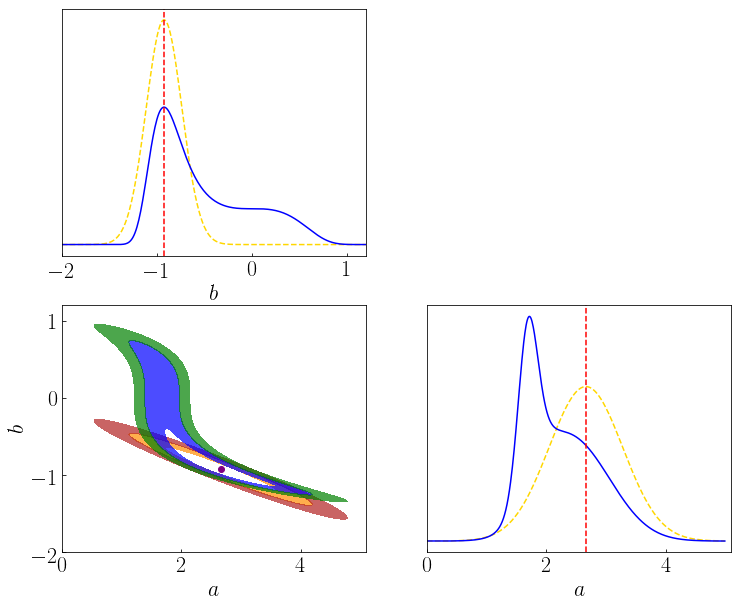

In [29]:
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(values_, marg_values_a_fisher, color='gold', linestyle='--')
plt.plot(values_, marg_values_a, color='b')
plt.axvline(b, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$b$')
plt.xlim(- 2., 1.2)
plt.yticks([])

plt.subplot(2, 2, 3)
plt.contourf(X, Y, Z_fisher, colors=['darkorange','firebrick'], alpha=0.7, levels=[2.3,6.2,11.8])
plt.contourf(X, Y, Z, colors=['blue','green'], alpha=0.7, levels=[2.3,6.2,11.8])
plt.scatter(a,b, color='purple')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

plt.subplot(2, 2, 4)
plt.plot(values_, marg_values_b_fisher, color='gold', linestyle='--')
plt.plot(values_, marg_values_b, color='b')
plt.tick_params(axis='both',direction='in')
plt.axvline(a, color='red', linestyle='--')
plt.xlabel(r'$a$')
plt.xlim(0, 5.1)
plt.yticks([])

plt.show()

And finally, the evidence:

In [30]:
evidence_2 = integrate.dblquad(lambda a, b: (1/24)*likeli_fisher(a,b), - 2, 2, 0, 6, epsabs=1.49e-30, epsrel=1.49e-30)[0]
evidence_2

7.576230399593337e-08

**5. Obtain the (full) 2D posterior and the marginalized 1D posteriors using the Metropolis algorithm.**

We must sample numbers given a distribution. In this case, we must draw numbers using the multivariate normal distribution, which is already implemented in `numpy`(np) python in the module `np.random.multivariate_normal` where er must give the mean (`initial_state`) and the covariance matrix. The covariance matrix is given by $$C=\frac{2.4^2}{D}F^{-1},$$ where $D$ is the dimention $D=2$ and $F^{-1}$ is the inverse of Fisher Matrix.

In [31]:
initial_state = [a, b] # BestFit Parameters
inverse_fisher = np.linalg.inv(fisher_matrix)
cov_fisher = ((2.4**2)/2)*inverse_fisher

n_mcs = 1e5 # Number of tries.

In [32]:
# Metropolis ALgorithm part.

mcmc_results = []
mcmc_results.append(initial_state)

for i in range(int(n_mcs)):
    random_candidate = np.random.multivariate_normal(initial_state, cov_fisher, 1)[0] # I Need this zero because I will apply this result in a function.
    fraction = posterior(random_candidate[0], random_candidate[1])/posterior(initial_state[0], initial_state[1])
    acceptance_probability = np.minimum(1, fraction)
    random_number = np.random.uniform(0, 1, 1)

    # Accept or Reject:
    if random_number <= acceptance_probability:
        mcmc_results.append(random_candidate)
        initial_state = random_candidate

mcmc_results = np.array(mcmc_results)

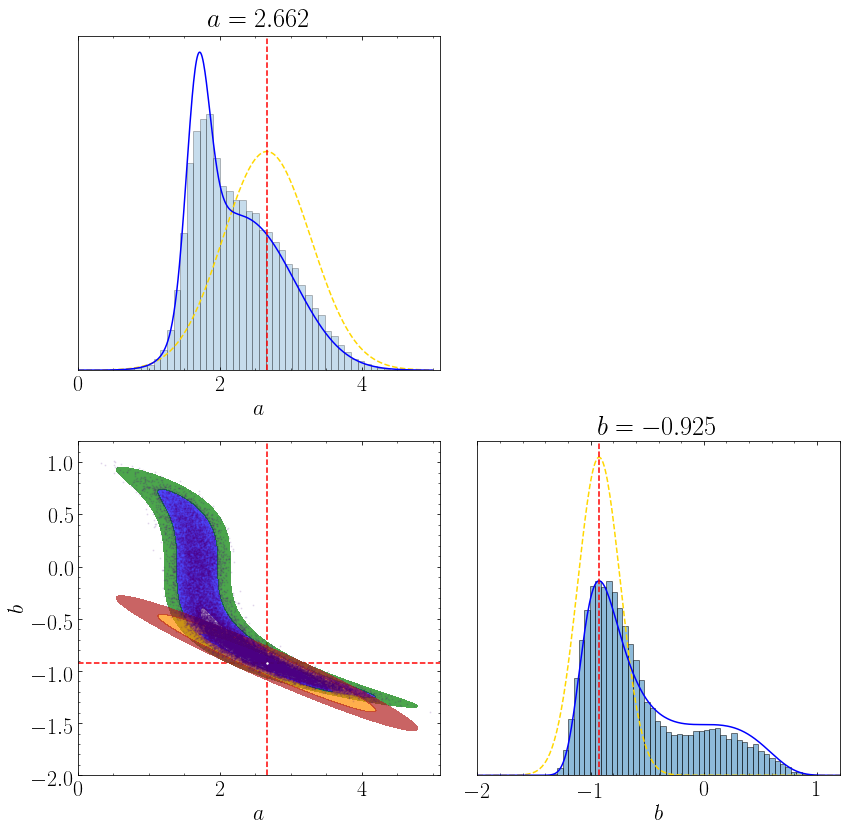

In [33]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.plot(values_, marg_values_b_fisher, color='gold', linestyle='--')
plt.plot(values_, marg_values_b, color='b')
plt.tick_params(axis='both',direction='in')
plt.axvline(a, color='red', linestyle='--')
plt.hist(mcmc_results[:,0], bins=50, density=1, alpha=0.25, ec='k')
plt.xlabel(r'$a$')
plt.xlim(0, 5.1)
plt.yticks([])
plt.minorticks_on()
plt.title(r'$a={{{}}}$'.format(np.round(a,3)), pad=10)
plt.tick_params(top=True, axis='both',direction='in', which='both')

plt.subplot(2, 2, 3)
plt.contourf(X, Y, Z, colors=['blue','green'], alpha=0.7, levels=[2.3,6.2,11.8], zorder=3)
plt.contourf(X, Y, Z_fisher, colors=['darkorange','firebrick'], alpha=0.7, levels=[2.3,6.2,11.8], zorder=4)
plt.plot(mcmc_results[:,0], mcmc_results[:,1], 'o' ,alpha = .1, color='indigo', markersize = 1, zorder=5)
plt.scatter(a,b, color='white', zorder=6, s = 2)
plt.tick_params(axis='both',direction='in')
plt.tick_params(axis='both',direction='in', which='both')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.axvline(a, color='red', linestyle='--', zorder=1)
plt.axhline(b, color='red', linestyle='--', zorder=2)
plt.minorticks_on()
plt.tick_params(top=True, axis='both',direction='in', which='both')
plt.tick_params(right=True, axis='both',direction='in', which='both')

plt.subplot(2, 2, 4)
plt.plot(values_, marg_values_a_fisher, color='gold', linestyle='--')
plt.plot(values_, marg_values_a, color='b')
plt.axvline(b, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.hist(mcmc_results[:,1], bins=50, density=1, alpha=0.5, ec='k')
plt.xlabel(r'$b$')
plt.title(r'$b={{{}}}$'.format(np.round(b,3)), pad=10)
plt.xlim(- 2., 1.2)
plt.tick_params(top=True, axis='both',direction='in', which='both')
plt.yticks([])
plt.minorticks_on()

plt.tight_layout()
plt.show()
# plt.savefig('my_corner_plot.png', dpi=300, bbox_inches='tight')

**6. Do a forecast assuming the fiducial values $a_\mathrm{fid}=3$, $b_\mathrm{fid}=-1$, the data error $\sigma=0.1$, a total of $N = 50$ measurements and the following values of the independent variable, $x_i = i/N$, with $i = 1,\ldots, N$ . Repeat the analysis of points 1-4.**

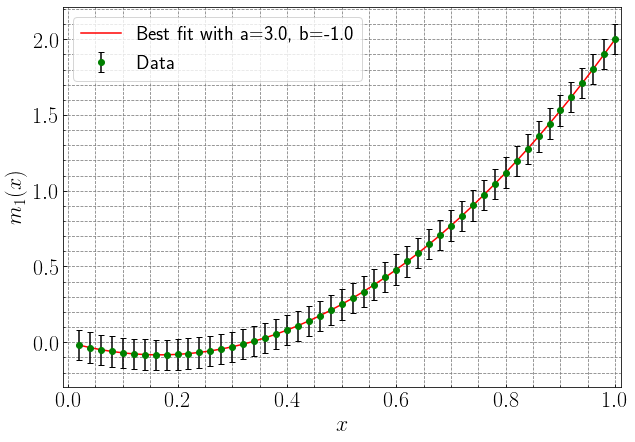

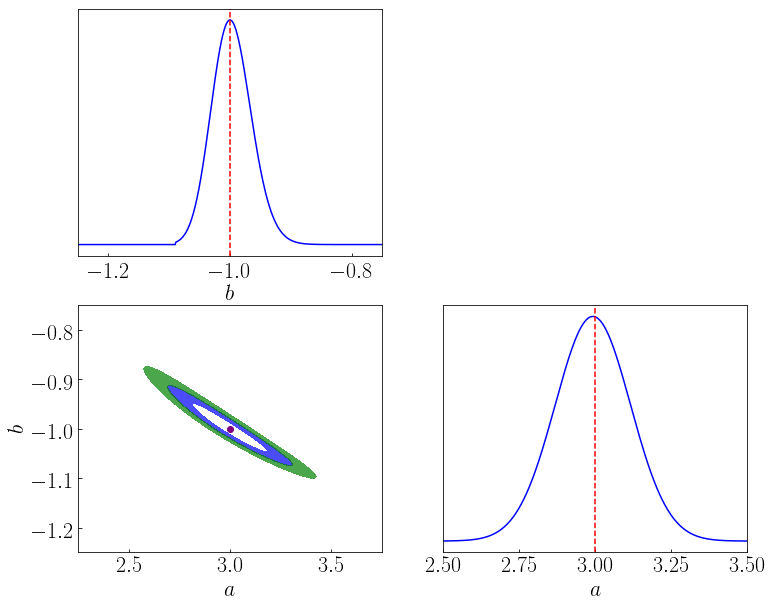

The evidence in this case is: 2.90199336275903e+26
Fisher Matrix:
[[ 1050.66664  3901.5    ]
 [ 3901.5     15453.     ]]


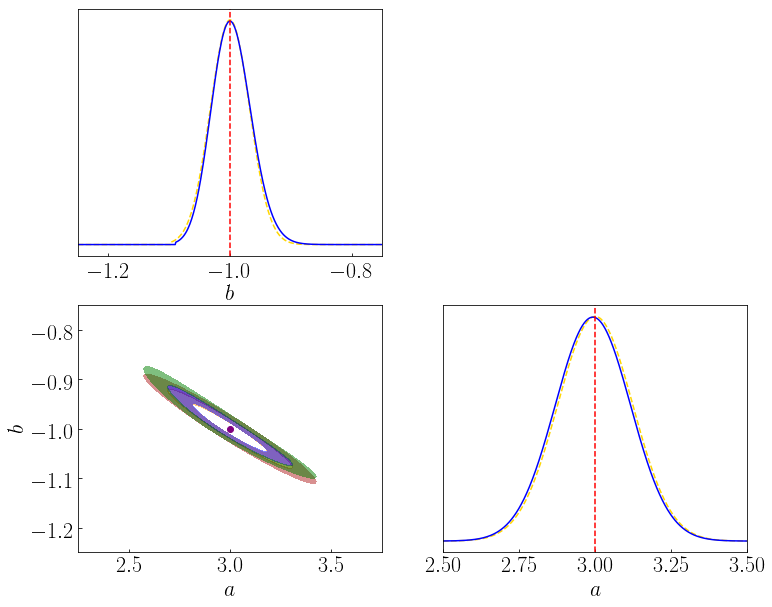

The evidence in this case is: 2.886686035208062e+26


In [34]:
# Part 1:
#########

N = 50
sigma_ = 0.1
a_fid = 3
b_fid = -1

x_ = np.arange(1, 50 + 1, 1)/50
cov_x_ = np.diag(np.ones(len(x_))*sigma_**2)
inverse_cov_x_ = np.linalg.inv(cov_x_)

# In this part, we'll generate artificial data given a model:
synthetic_data_m1_ = a_fid*x_**2 + (b_fid**3)*x_

# Evaluating the constant term in the Likelihood function:
norm_term_ = np.sqrt(np.linalg.det(2*np.pi*cov_x_))**(- 1)

def chi2_func_(a,b):
    model = a*x_**2 + (b**3)*x_
    vector = synthetic_data_m1_ - model
    return np.dot(vector, np.dot(inverse_cov_x_, vector))

def like_func_(a,b):
    return np.exp(-(1/2)*chi2_func_(a,b))*norm_term_

def int__():
    f = lambda a, b: like_func_(a,b)
    return integrate.dblquad(f, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

f_D_ = int__()

# This is the posterior function:
def posterior_(a,b):
    return like_func_(a,b)/f_D_

def chi2_func_forminimize_(params):
    a, b = params
    model = a*x_**2 + (b**3)*x_
    vector = synthetic_data_m1_ - model
    return np.dot(vector, np.dot(inverse_cov_x_, vector))

bounds = [(-1000, 1000), (-1000, 1000)] # Bounds for the parameters.
result_ = differential_evolution(chi2_func_forminimize_, bounds)

a_ = result_.x[0]
b_ = result_.x[1]

plt.figure(figsize=(10,7))
plt.errorbar(x_, synthetic_data_m1_, sigma_, fmt='og', label='Data', ecolor='k', capsize=3)
plt.plot(x_, a_*x_**2+b_**3*x_, '-r', label=r'Best fit with a={}, b={}'.format(np.around(a_, 3),np.around(b_, 3)))
plt.legend(fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$m_1(x)$')
plt.tick_params(axis='both',direction='in', which='both')
plt.grid(which='both', color='gray', linestyle='--')
plt.minorticks_on()
plt.xlim(-0.01,1.01)

plt.show()

# Part 2:
#########

# For the marginalized posteriors:
def mar_a_(b):
    return integrate.quad(lambda a: posterior_(a,b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_a_ = np.vectorize(mar_a_)
values_ = np.arange(-1.25,3.75,.001)
marg_values_a_ = vec_mar_a_(values_)

def mar_b_(a):
    return integrate.quad(lambda b: posterior_(a,b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_b_ = np.vectorize(mar_b_)
marg_values_b_ = vec_mar_b_(values_)

def contour_posterior_(a, b):
    return - 2*np.log(posterior_(a,b)) + 2*np.log(posterior_(a_,b_))

vec_contour_posterior_ = np.vectorize(contour_posterior_)

# Some values:
xa = np.linspace(2.25, 3.75, 1000)
yb = np.linspace(- 1.25, -0.75, 1000)

X, Y = np.meshgrid(xa, yb)
Z_ = vec_contour_posterior_(X, Y)

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(values_, marg_values_a_, color='b')
plt.axvline(b_, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$b$')
plt.xlim(- 1.25, -0.75)
plt.yticks([])

plt.subplot(2, 2, 3)
plt.contourf(X, Y, Z_, colors=['blue','green'], alpha=0.7, levels=[2.3,6.2,11.8])
plt.scatter(a_,b_, color='purple')
plt.tick_params(axis='both',direction='in')
plt.ylim(- 1.25, -0.75)
plt.xlim(2.25, 3.75)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

plt.subplot(2, 2, 4)
plt.plot(values_, marg_values_b_, color='b')
plt.tick_params(axis='both',direction='in')
plt.axvline(a_, color='red', linestyle='--')
plt.xlabel(r'$a$')
plt.xlim(2.5, 3.5)
plt.yticks([])

plt.show()

# Part 3:
#########

evidence_1_ = integrate.dblquad(lambda a, b: (1/24)*like_func_(a,b), - 2, 2, 0, 6, epsabs=1.49e-30, epsrel=1.49e-30)[0]
print('The evidence in this case is: {}'.format(evidence_1_))

# Part 4:
#########

fisher_terms_sympy_ = sympy.simplify(- sympy.log(norm_term_*sympy.exp(- (1/2)*chi2_func_(A,B))))

fisher_AA_ = sympy.diff(fisher_terms_sympy_, A, 2)
fisher_AB_ = sympy.diff(sympy.diff(fisher_terms_sympy_, A, 1), B, 1)
fisher_BA_ = sympy.diff(sympy.diff(fisher_terms_sympy_, B, 1), A, 1)
fisher_BB_ = sympy.diff(fisher_terms_sympy_, B, 2)

# To evaluate all terms in fisher matrix using the best-fit values:
fisher_aa_ = fisher_AA_.subs([('A', a_), ('B', b_)])
fisher_ab_ = fisher_AB_.subs([('A', a_), ('B', b_)])
fisher_ba_ = fisher_BA_.subs([('A', a_), ('B', b_)])
fisher_bb_ = fisher_BB_.subs([('A', a_), ('B', b_)])

fisher_matrix_ = np.array([[fisher_aa_, fisher_ab_], [fisher_ba_, fisher_bb_]], dtype=float)

print('Fisher Matrix:')
print(fisher_matrix_)

def likeli_fisher_(a__, b__):
    best_fit = np.array([a_, b_])
    fisher_params = np.array([a__, b__])
    diff = best_fit - fisher_params
    return norm_term_*np.exp(-(1/2)*np.dot(diff, np.dot(fisher_matrix_, diff)))

normalization_constant_ = integrate.dblquad(likeli_fisher_, - np.inf, np.inf, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

def posterior_fisher_(a_, b_):
    return likeli_fisher_(a_, b_)/normalization_constant_

# Contour values:
def contour_posterior_fisher_(a__, b__):
    return - 2*np.log(posterior_fisher_(a__,b__)) + 2*np.log(posterior_fisher_(a_,b_))

vec_contour_posterior_fisher_ = np.vectorize(contour_posterior_fisher_)

# Some values:
Z_fisher_ = vec_contour_posterior_fisher_(X, Y)

# For the marginalized posteriors:
def mar_a_fisher_(b):
    return integrate.quad(lambda a_: posterior_fisher_(a_, b), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_a_fisher_ = np.vectorize(mar_a_fisher_)
# values_ = np.arange(-2,5,.01)
marg_values_a_fisher_ = vec_mar_a_fisher_(values_)

def mar_b_fisher_(a):
    return integrate.quad(lambda b_: posterior_fisher_(a,b_), - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

vec_mar_b_fisher_ = np.vectorize(mar_b_fisher_)
marg_values_b_fisher_ = vec_mar_b_fisher_(values_)

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(values_, marg_values_a_fisher_, color='gold', linestyle='--')
plt.plot(values_, marg_values_a_, color='b')
plt.axvline(b_, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$b$')
plt.xlim(- 1.25, -0.75)
plt.yticks([])

plt.subplot(2, 2, 3)
plt.contourf(X, Y, Z_fisher_, colors=['darkorange','firebrick'], alpha=0.5, levels=[2.3,6.2,11.8])
plt.contourf(X, Y, Z_, colors=['blue','green'], alpha=0.5, levels=[2.3,6.2,11.8])
plt.scatter(a_,b_, color='purple')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.ylim(- 1.25, -0.75)
plt.xlim(2.25, 3.75)

plt.subplot(2, 2, 4)
plt.plot(values_, marg_values_b_fisher_, color='gold', linestyle='--')
plt.plot(values_, marg_values_b_, color='b')
plt.tick_params(axis='both',direction='in')
plt.axvline(a_, color='red', linestyle='--')
plt.xlabel(r'$a$')
plt.xlim(2.5, 3.5)
plt.yticks([])

plt.show()

evidence_2_ = integrate.dblquad(lambda a, b: (1/24)*likeli_fisher_(a,b), - 2, 2, 0, 6, epsabs=1.49e-30, epsrel=1.49e-30)[0]
print('The evidence in this case is: {}'.format(evidence_2_))

**7. Consider now the model $M_2$ given by $m_2(x)=ax^3$. Repeat the analysis of points 1-3.**

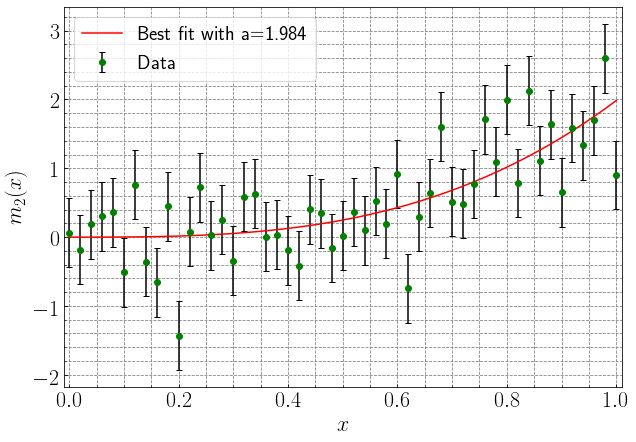

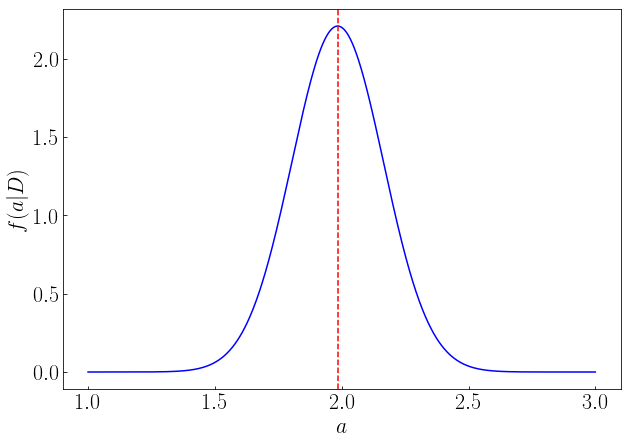

The evidence in this case is: 3.8746233281710045e-19


In [35]:
# Part 1:
#########

# norm_term__ = np.sqrt(2*np.pi*cov_matrix[0,0])**(- 1) This is wrong!
# The data likelihood never change.

def chi2_func__(a):
    model = a*x**3
    vector = d - model
    return np.dot(vector, np.dot(inverse_cov_matrix, vector))

def like_func__(a):
    return np.exp(-(1/2)*chi2_func__(a))*norm_term

def int___():
    f = lambda a: like_func__(a)
    return integrate.quad(f, - np.inf, np.inf, epsabs=1.49e-30, epsrel=1.49e-30)[0]

f_D___ = int___()

# This is the posterior function:
def posterior__(a):
    return like_func__(a)/f_D___

def chi2_func_forminimize__(params):
    a = params
    model = a*x**3
    vector = d - model
    return np.dot(vector, np.dot(inverse_cov_matrix, vector))

bounds = [(-1000, 1000)] # Bounds for the parameters.
result_ = differential_evolution(chi2_func_forminimize__, bounds)

a___ = result_.x[0]

plt.figure(figsize=(10,7))
plt.errorbar(x, d, sigmas, fmt='og', label='Data', ecolor='k', capsize=3)
plt.plot(x, a___*x**3, '-r', label=r'Best fit with a={}'.format(np.around(a___, 3)))
plt.legend(fontsize=20)
plt.xlabel(r'$x$')
plt.ylabel(r'$m_2(x)$')
plt.tick_params(axis='both',direction='in', which='both')
plt.grid(which='both', color='gray', linestyle='--')
plt.minorticks_on()
plt.xlim(-0.01,1.01)

plt.show()

# Part 2:
#########

# There is no marginalization to do here...

# Also not necessary:
# def contour_posterior__(a):
#     return - 2*np.log(posterior__(a))

vec_posterior__ = np.vectorize(posterior__)

# Some values:
xa = np.linspace(1, 3, 1000)

plt.figure(figsize=(10,7))

plt.plot(xa, vec_posterior__(xa), color='b')
plt.axvline(a___, color='red', linestyle='--')
plt.tick_params(axis='both',direction='in')
plt.xlabel(r'$a$')
plt.ylabel(r'$f(a|D)$')

plt.show()

# Part 3:
#########

evidence_ = integrate.quad(lambda a: (1/6)*like_func__(a), 0, 6, epsabs=1.49e-30, epsrel=1.49e-30)[0]
print('The evidence in this case is: {}'.format(evidence_))

**8. Carry out model selection using, $\chi^2_{\mathrm{min}}$, $\mathrm{AIC}=\chi^2_\mathrm{min}+2M$, $\mathrm{BIC}=\chi^2_\mathrm{min}+M\ln N$ and $B_{12}$. Obtain the Occam factor $\Omega$.**

In [36]:
# M is the number of parameters
# N is the number of data

# For AIC:
aic_1 = chi2_func(a, b) + 2*(2)
aic_2 = chi2_func__(a___) + 2*(1)

# For BIC:
bic_1 = chi2_func(a, b) + 2*np.log(51)
bic_2 = chi2_func__(a___) + 1*np.log(51)

bayes_factor = evidence_1/evidence_

Occam_factor = bayes_factor*(like_func__(a___)/like_func(a,b))

In [37]:
print('Results:')
print('--------')

print('AIC Model 1 = {}'.format(aic_1))
print('AIC Model 2 = {}'.format(aic_2))
print('BIC Model 1 = {}'.format(bic_1))
print('BIC Model 2 = {}'.format(bic_2))
print('Bayes Factor = {}'.format(bayes_factor))
print('Occam Factor = {}'.format(Occam_factor))

Results:
--------
AIC Model 1 = 59.556423348502605
AIC Model 2 = 58.591603539329775
BIC Model 1 = 63.42007461395126
BIC Model 2 = 60.5234291720541
Bayes Factor = 0.27600056293646874
Occam Factor = 0.16448391922013905


After open the wrong door, this kid didn't find his hot wheels car...

![Alt Text](http://www.doseoffunny.com/wp-content/uploads/2014/04/tumblr_mp4nf8v1gF1qdlh1io1_400.gif)